In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import networkx as nx
import ast

from nanonets import Simulation
from nanonets.utils import extract_harmonic_features
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.signal import correlate2d, correlate
from scipy.optimize import curve_fit
from scipy.linalg import eig

plt.style.use(["science","bright","grid"])
PATH = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/amp_freq_size/"
# PATH = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/AC/amp_freq/"
# PATH = "/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/AC/amp_freq_size/"

def get_lattice_electrode_cap_matrix(L: int):
    topo = {"Nx": L,"Ny": L,
            "e_pos": [[(L-1)//2, 0],[0, 0],[L-1, 0],
                    [0, (L-1)//2],[L-1, (L-1)//2],
                    [0, L-1],[L-1, L-1],[(L-1)//2, L-1]],
            "electrode_type": ['constant']*8}
    sim  = Simulation(topo)
    return sim.get_electrode_capacitance_matrix()

def get_displacement_currents(pots:np.ndarray, C_U: np.ndarray, dt: float, output_idx=-1):
    """
    Calculates the total displacement current flowing into the output electrode.
    
    This function computes I_disp(t) = C_out_vec · d(phi_vec)/dt.
    It accounts for the contribution of every nanoparticle in the network, 
    weighted by its mutual capacitance to the output.

    Parameters:
    -----------
    pots : np.ndarray
        Array of shape (steps, N_p) containing the time series of potentials 
        for all N_p nanoparticles.
    C_U : np.ndarray
        The electrode capacitance matrix of shape (N_p, N_e).
    dt : float
        The simulation time step size (in seconds, or consistent units).
    output_idx : int, optional
        The column index in C_U corresponding to the output electrode. 
        Default is -1 (the last column).

    Returns:
    --------
    I_disp : np.ndarray
        Array of shape (steps - 1,). The displacement current time series.
        Note: The length is one less than 'pots' because differentiation 
        consumes one data point.
    """

    # 1. Extract the coupling vector for the output electrode
    # Shape: (N_p,) - This is the vector \vec{C}_{out}
    C_out_vec = C_U[:, output_idx]

    # 2. Calculate the time derivative of the potential vector
    # We use numerical differentiation: d_phi/dt approx (phi(t+1) - phi(t)) / dt
    # Shape: (steps - 1, N_p)
    d_phi_dt = np.gradient(pots, dt, axis=0)

    # 3. Compute the displacement current
    # We perform a dot product sum over the N_p dimension for each time step.
    # Mathematical operation: I(t) = \sum_{i} C_{i,out} * \dot{\phi}_i(t)
    # Using matrix multiplication (@) handles this sum efficiently.
    # (steps-1, N_p) @ (N_p,) -> (steps-1,)
    I_disp = d_phi_dt @ C_out_vec

    return I_disp

In [141]:
# PARAMETER
N_PARTICLES     = [3,5,7,9,11,13]
AMPLITUDE       = 0.02
AMPLITUDE_LIST  = [AMPLITUDE]
FREQ_LIST_MHZ   = [0.005,0.01,0.03,0.06,0.12,0.25,0.5,1.,2.,5.,6.,8.,
                   10.,12.,15.,18.,23.,28.,36.,44.,55.,68.,86.,105.,133.,266.,610.,1200.,2400.]
N_PERIODS       = 100
N_SKIP          = 80
SAMPLE_P_PERIOD = 40
N_ELECTRODES    = 8
N_NP            = 9
PLOT_SIZE_NORM  = Normalize(vmin=N_PARTICLES[0]**2, vmax=N_PARTICLES[-1]**2)
C_US            = {N : get_lattice_electrode_cap_matrix(N).T for N in N_PARTICLES}

# Normalization
topo        = {"Nx" : 1, "Ny" : 1, "electrode_type" : ['constant','constant']}
sim_c       = Simulation(topo)
C_total     = sim_c.get_capacitance_matrix()[0][0]*1e-18
R_junction  = 25*1e6
TAU_SET     = R_junction * C_total
F0_SET      = (1e-6)/(2*np.pi*TAU_SET)

### Linear Limit

In [ ]:
tau_t = {}
f_c_t = {}
for N_P in N_PARTICLES:
    topo = {"Nx": N_P,"Ny": N_P,
            "e_pos": [[(N_P-1)//2, 0],[0, 0],[N_P-1, 0],
                    [0, (N_P-1)//2],[N_P-1, (N_P-1)//2],
                    [0, N_P-1],[N_P-1, N_P-1],[(N_P-1)//2, N_P-1]],
            "electrode_type": ['constant']*8}
    
    sim_c = Simulation(topo)
    sim_c.build_conductance_matrix()
    cap_m           = sim_c.get_capacitance_matrix()*1e-18
    g_m             = sim_c.get_conductance_matrix()[:-8,:-8]
    eigenvalues, _  = eig(g_m, cap_m)
    real_eigs       = np.real(eigenvalues)
    valid_eigs      = real_eigs[real_eigs > 1e-9]

    lambda_min = np.min(valid_eigs)
    tau_t[N_P] = 1.0 / lambda_min
    f_c_t[N_P] = lambda_min / (2*np.pi)

def power_law(x,a,b):
    return a*x**b

fig, ax = plt.subplots(dpi=200)
x_val   = np.linspace(N_PARTICLES[0],N_PARTICLES[-1],100)
p, _    = curve_fit(power_law, np.array(N_PARTICLES)[1:], [tau_t[N] for N in N_PARTICLES][1:])
pp      = ax.plot(np.array(N_PARTICLES), np.array([tau_t[N] for N in N_PARTICLES])*1e9, 'o')
_       = ax.plot(x_val, power_law(x_val, *p)*1e9, color=pp[0].get_color(), label=rf'$\tau_0 \propto L^{{{p[-1]:.2f}}}$')
_       = ax.set_xticks(N_PARTICLES)
_       = ax.set_xlabel("$L$")
_       = ax.set_ylabel("$\\tau_0~[ns]$")
leg     = ax.legend(fontsize='small')

### Load Data

In [ ]:
dts         = {freq : 1/(40 * freq * 1e6) for freq in FREQ_LIST_MHZ}
N_steps     = {freq : int(np.ceil((N_PERIODS / (freq * 1e6)) / dts[freq])) for freq in FREQ_LIST_MHZ}
time        = {freq : dts[freq]*np.arange(N_steps[freq]) for freq in FREQ_LIST_MHZ}
data        = {N : {freq : pd.read_csv(f"{PATH}Nx={N}_Ny={N}_Ne=8_{freq:.3f}_{AMPLITUDE:.3f}.csv") for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
states      = {N : {freq : pd.read_csv(f"{PATH}mean_state_Nx={N}_Ny={N}_Ne=8_{freq:.3f}_{AMPLITUDE:.3f}.csv") for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
# currents    = {N : {freq : pd.read_csv(f"{PATH}net_currents_Nx={N}_Ny={N}_Ne=8_{freq:.3f}_{AMPLITUDE:.3f}.csv").iloc[N_SKIP*SAMPLE_P_PERIOD:,:]*1e-6
#                       for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}

In [26]:
x   = {N : {freq : data[N][freq]['E0'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
y_t = {N : {freq : data[N][freq]['Observable'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
y_e = {N : {freq : data[N][freq]['Error'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
p   = {N : {freq : states[N][freq].iloc[:,8:].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
p_m = {N : {freq : np.mean(states[N][freq].iloc[:,8:].values, axis=1)[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
y_d = {N : {freq : get_displacement_currents(p[N][freq], C_US[N], dts[freq]) for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
y   = {N : {freq : y_t[N][freq]+y_d[N][freq] for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}

In [ ]:
# save_folder = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/dynamic/AC/amp_freq_size/"
# for N in N_PARTICLES:
#     for freq in FREQ_LIST_MHZ:
        # np.save(f"{save_folder}_x_{N}_{freq}.npy", x[N][freq])
        # np.save(f"{save_folder}_y_{N}_{freq}.npy", y[N][freq])
        # np.save(f"{save_folder}_p_{N}_{freq}.npy", p[N][freq])
        # np.save(f"{save_folder}_states_{N}_{freq}.npy", states[N][freq].iloc[N_SKIP*SAMPLE_P_PERIOD:,8:].values)
        # currents[N][freq].to_csv(f"{save_folder}_I_{N}_{freq}.csv")

In [ ]:
# x   = {}
# y   = {}
# p   = {}
# p_s = {}
# for N in N_PARTICLES:
#     x_tmp   = {}
#     y_tmp   = {}
#     p_tmp   = {}
#     p_s_tmp = {}
#     for freq in FREQ_LIST_MHZ:
#         x_tmp[freq] = np.load(f"{save_folder}_x_{N}_{freq}.npy")
#         y_tmp[freq] = np.load(f"{save_folder}_y_{N}_{freq}.npy")
#         p_tmp[freq] = np.load(f"{save_folder}_p_{N}_{freq}.npy")
#         p_s_tmp[freq] = np.load(f"{save_folder}_states_{N}_{freq}.npy")
#     x[N]    = x_tmp
#     y[N]    = y_tmp
#     p[N]    = p_tmp
#     p_s[N]  = p_s_tmp
#     currents[N][freq].to_csv(f"{save_folder}_I_{N}_{freq}.csv")

### AC-Gain vs System Size

In [30]:
B       = 200
h0s_p   = {N : np.array([extract_harmonic_features(p_m[N][f0], n_vals=[1], mode='abs', pad_len=4096) for f0 in FREQ_LIST_MHZ]).flatten() for N in N_PARTICLES}
h0s_I   = {N : np.array([[extract_harmonic_features(y[N][f0]+np.random.normal(0, y_e[N][f0]/1.96), n_vals=[1], mode='abs', pad_len=4096) for _ in range(B)] for f0 in FREQ_LIST_MHZ]) for N in N_PARTICLES}
gain_p  = {N : 20*np.log10(h0s_p[N]/h0s_p[N][0]) for N in N_PARTICLES}
gain_I  = {N : 20*np.log10(h0s_I[N]/h0s_I[N][0]) for N in N_PARTICLES}

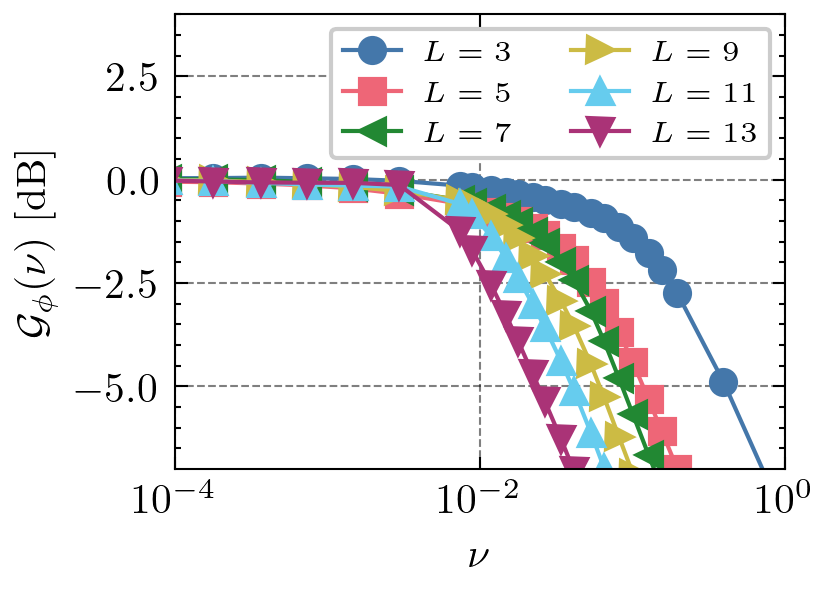

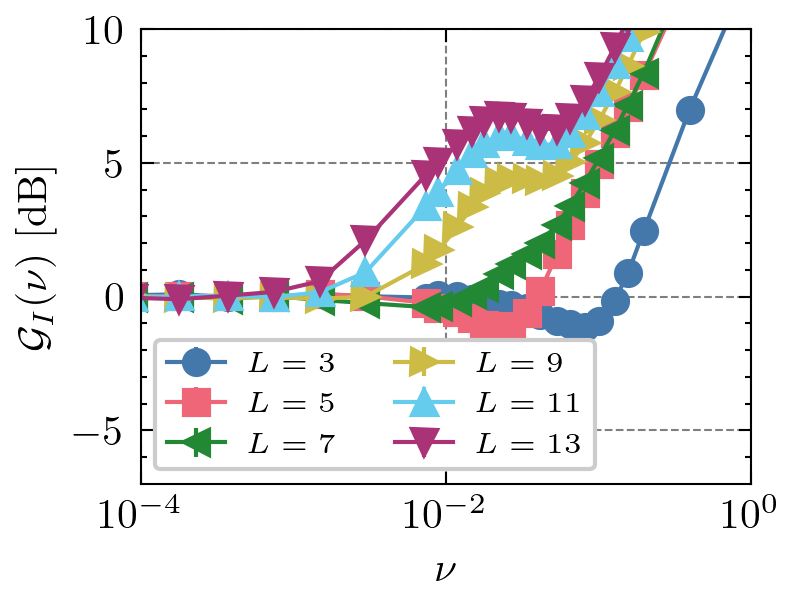

In [148]:
cmap    = plt.get_cmap('cividis')
marker  = ['o','s','<','>','^','v']

fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

# Potential
for i, N in enumerate(N_PARTICLES):
    ax.plot(np.array(FREQ_LIST_MHZ)/F0_SET, gain_p[N], marker=marker[i], label=rf'$L = {N}$')
_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_ylabel("$\mathcal{G}_\phi(\\nu)$ [dB]")
_ = ax.set_xlim(1e-4,1e0)
_ = ax.set_ylim(-7,4)
_ = ax.legend(fontsize='x-small', loc='upper right', ncol=2)

fig.savefig(f"plots/pdf/pot_f0_gain_scaling.pdf", transparent=False)
fig.savefig(f"plots/svg/pot_f0_gain_scaling.svg", transparent=True)
fig.savefig(f"plots/png/pot_f0_gain_scaling.png", transparent=False)

fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

# Current
for i, N in enumerate(N_PARTICLES):
    ax.errorbar(np.array(FREQ_LIST_MHZ)/F0_SET, np.mean(gain_I[N],axis=1).flatten(), np.std(gain_I[N],axis=1).flatten(), marker=marker[i], label=rf'$L = {N}$')
_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_ylabel("$\mathcal{G}_{I}(\\nu)$ [dB]")
_ = ax.set_xlim(1e-4,1e0)
_ = ax.set_ylim(-7,10)
_ = ax.legend(fontsize='x-small', loc='lower left', ncol=2)

fig.savefig(f"plots/pdf/I_f0_gain_scaling.pdf", transparent=False)
fig.savefig(f"plots/svg/I_f0_gain_scaling.svg", transparent=True)
fig.savefig(f"plots/png/I_f0_gain_scaling.png", transparent=False)

In [149]:
def extract_fc_from_gain(freqs, gain_db, threshold=-3.0):
    """Interpolates the frequency where Gain crosses threshold."""
    # Assuming monotonic rolloff in the cutoff region
    # Find last point above and first point below
    
    # Safety: Check if we ever cross
    if np.min(gain_db) > threshold:
        return np.nan
    
    # Find index where it drops
    idx = np.where(gain_db < threshold)[0][0]
    
    if idx == 0: return np.nan # Started below
    
    f1, f2 = freqs[idx-1], freqs[idx]
    g1, g2 = gain_db[idx-1], gain_db[idx]
    
    # Linear interpolation
    slope = (f2 - f1) / (g2 - g1)
    f_c = f1 + slope * (threshold - g1)
    
    return f_c

fc_pot      = np.array([extract_fc_from_gain(FREQ_LIST_MHZ, gain_p[N]) for N in N_PARTICLES])/F0_SET
# fc_current  = []

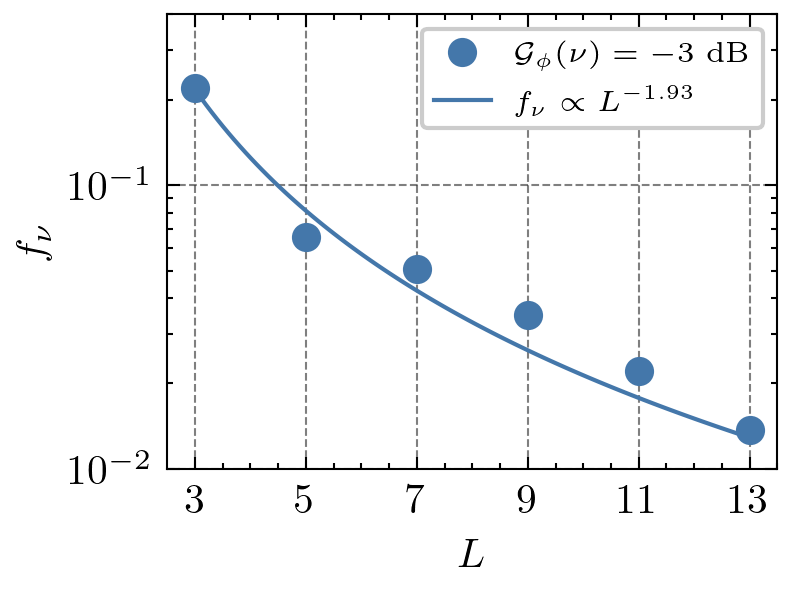

In [162]:
def power_law(x,a,b):
    return a*x**b

fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

f_vals  = np.linspace(N_PARTICLES[0], N_PARTICLES[-1], 100)
pp      = ax.plot(np.array(N_PARTICLES), fc_pot, marker='o', label='$\mathcal{G}_{\phi}(\\nu) = -3~\mathrm{dB}$', ls='')
# _       = ax.plot(np.array(N_PARTICLES), fc_current, marker='s', label='$\mathcal{G}_{I}(f_c) = -3~\mathrm{dB}$')
pa,_    = curve_fit(power_law, np.array(N_PARTICLES), fc_pot)
_       = ax.plot(f_vals, power_law(f_vals,*pa), label=f'$f_\\nu \propto L^{{{pa[1]:.2f}}}$', color=pp[0].get_color())
_       = ax.set_ylabel('$f_\\nu$')
_       = ax.set_xlabel('$L$')
_       = ax.legend(fontsize='x-small')
_       = ax.set_yscale('log')
_       = ax.set_ylim(1e-2,4e-1)
_       = ax.set_xticks(N_PARTICLES)

fig.savefig(f"plots/pdf/fc_scaling.pdf", transparent=False)
fig.savefig(f"plots/svg/fc_scaling.svg", transparent=True)
fig.savefig(f"plots/png/fc_scaling.png", transparent=False)

### Phase Lag

In [163]:
def get_phase_lag(response_signal: np.ndarray, input_signal: np.ndarray) -> float:
    """
    Calculates the Phase Lag between a system response and the driving input 
    at the fundamental driving frequency.
    
    Formula: Phase = Angle(Response) - Angle(Input)
    
    Parameters:
    -----------
    response_signal : np.ndarray
        The output time series (e.g., spatially averaged potential or total current).
        Shape: (steps,)
    input_signal : np.ndarray
        The driving input time series (e.g., sine wave voltage).
        Shape: (steps,)
        
    Returns:
    --------
    phase_deg : float
        The phase shift in degrees.
        Range is normalized to [-180, 180]. 
        Negative values indicate the response 'lags' behind the input (Capacitive).
        Positive values indicate the response 'leads' the input (Inductive).
    """
    
    # 1. Apply Windowing (Optional but recommended to reduce spectral leakage)
    # If your signal is an exact integer number of periods, you can skip this.
    # Otherwise, a Hanning window helps.
    window = np.hanning(len(response_signal))
    resp_w = response_signal * window
    input_w = input_signal * window
    
    # 2. Compute FFT
    # We use rfft because the signals are real-valued
    fft_resp = np.fft.rfft(resp_w)
    fft_in = np.fft.rfft(input_w)
    
    # 3. Find the Fundamental Frequency Index
    # We assume the input is a dominant sine wave, so we just find the max peak.
    # We skip index 0 (DC component).
    idx_fund = np.argmax(np.abs(fft_in[1:])) + 1
    
    # 4. Extract Angles (Phases) at that index
    angle_resp = np.angle(fft_resp[idx_fund])
    angle_in = np.angle(fft_in[idx_fund])
    
    # 5. Calculate Difference
    phase_diff = angle_resp - angle_in
        
    # 7. Normalize to [-180, 180] range
    # This handles wrap-around (e.g., if result is -270, it becomes +90)
    phase_diff = (phase_diff + np.pi) % (2 * np.pi) - np.pi
    
    return phase_diff / np.pi

In [164]:
phase_s = {N : [get_phase_lag(p_m[N][freq],x[N][freq]) for freq in FREQ_LIST_MHZ] for N in N_PARTICLES}
phase_I = {N : [get_phase_lag(y[N][freq],x[N][freq]) for freq in FREQ_LIST_MHZ] for N in N_PARTICLES}

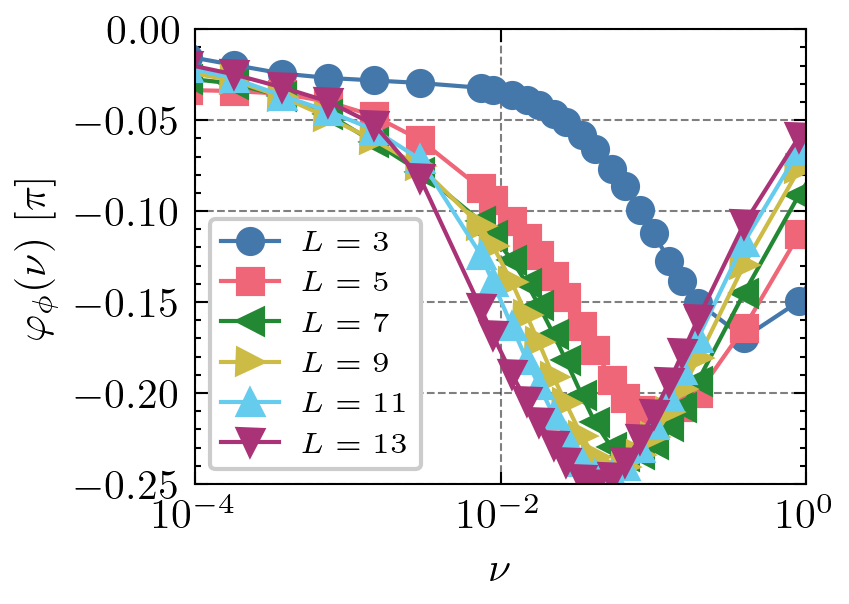

In [228]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
for i, N in enumerate(N_PARTICLES):
    _   = ax.plot(np.array(FREQ_LIST_MHZ)/F0_SET, phase_s[N], marker=marker[i], label=rf'$L = {N}$')

_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_ylabel("$\\varphi_{\phi}(\\nu)~[\mathrm{\pi}]$")
_ = ax.legend(fontsize='x-small', loc='lower left', ncol=1)
_ = ax.set_ylim(-0.25,0)
_ = ax.set_xlim(1e-4,1e0)

fig.savefig(f"plots/pdf/pot_f0_phase_scaling.pdf", transparent=False)
fig.savefig(f"plots/svg/pot_f0_phase_scaling.svg", transparent=True)
fig.savefig(f"plots/png/pot_f0_phase_scaling.png", transparent=False)

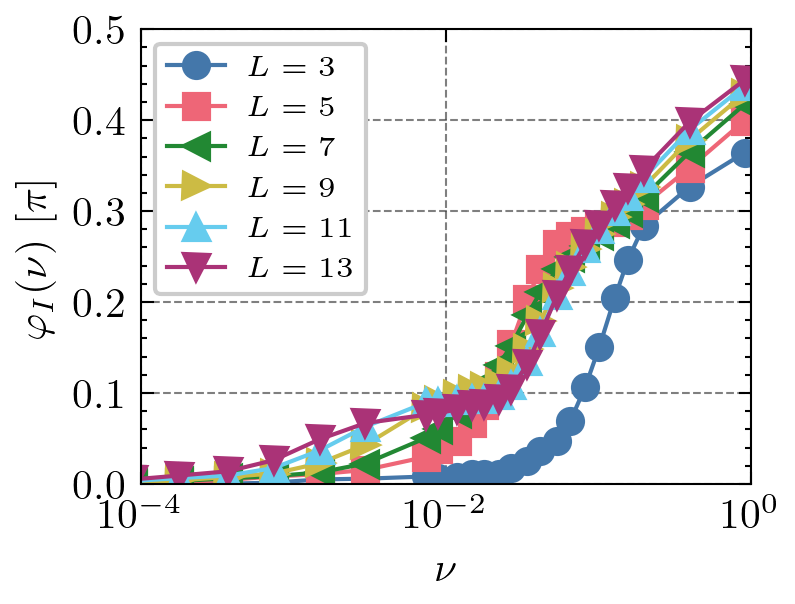

In [227]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
for i, N in enumerate(N_PARTICLES):
    _   = ax.plot(np.array(FREQ_LIST_MHZ)/F0_SET, phase_I[N], marker=marker[i], label=rf'$L = {N}$')

_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_ylabel("$\\varphi_{I}(\\nu)~[\mathrm{\pi}]$")
_ = ax.legend(fontsize='x-small', loc='upper left', ncol=1)
_ = ax.set_ylim(0,0.5)
_ = ax.set_xlim(1e-4,1e0)

fig.savefig(f"plots/pdf/I_f0_phase_scaling.pdf", transparent=False)
fig.savefig(f"plots/svg/I_f0_phase_scaling.svg", transparent=True)
fig.savefig(f"plots/png/I_f0_phase_scaling.png", transparent=False)

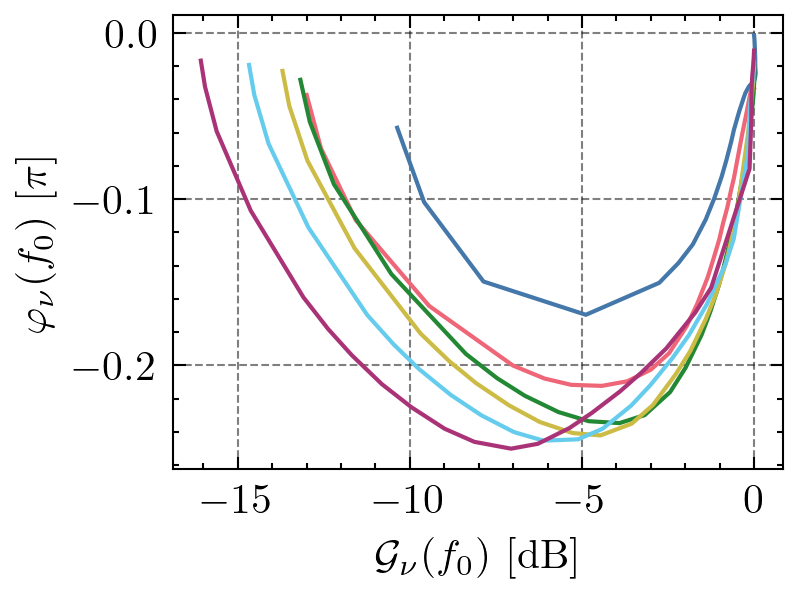

In [167]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

for N in N_PARTICLES:
    _ = ax.plot(gain_p[N],phase_s[N])

_ = ax.set_ylabel("$\\varphi_{\\nu}(f_0)~[\mathrm{\pi}]$")
_ = ax.set_xlabel("$\mathcal{G}_{\\nu}(f_0)$ [dB]")

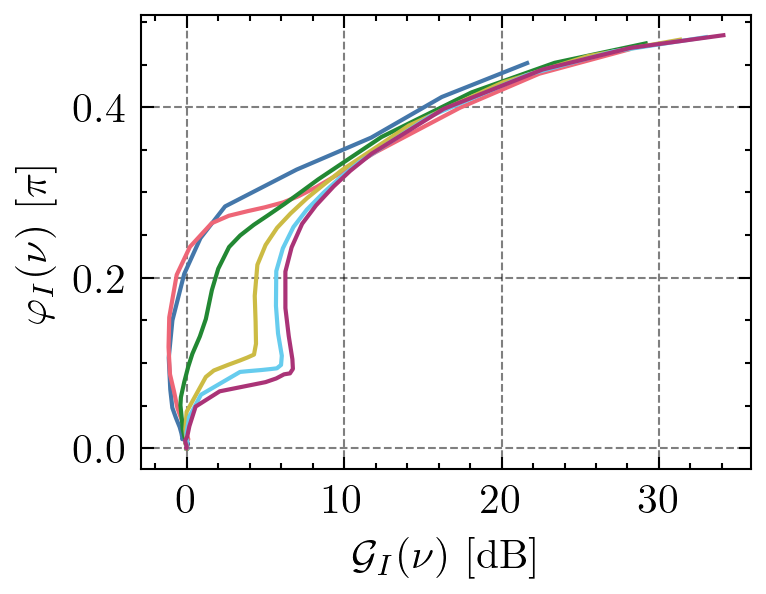

In [168]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

for N in N_PARTICLES:
    _ = ax.plot(np.mean(gain_I[N],axis=1).flatten(),phase_I[N])

_ = ax.set_ylabel("$\\varphi_{I}(\\nu)~[\mathrm{\pi}]$")
_ = ax.set_xlabel("$\mathcal{G}_{I}(\\nu)$ [dB]")

### THD and Centroid

In [118]:
def compute_spectral_centroid(amplitudes, harmonic_orders, exclude_fundamental=True):
    """
    Calculates the Spectral Centroid (Center of Mass of the Harmonic Spectrum).
    
    Formula: C = Sum(n * A_n^2) / Sum(A_n^2)
    (Weighted by Power, consistent with energy distribution)
    
    Parameters:
    - amplitudes: Array of magnitudes [A_1, A_3, A_5...]
    - harmonic_orders: Array of harmonic indices [1, 3, 5...]
    - exclude_fundamental: If True, calculates the centroid of the DISTORTION only (n > 1).
                           If False, includes the fundamental frequency.
    
    Returns:
    - centroid: The weighted average harmonic order (e.g., 3.5 means energy is between n=3 and n=5).
    """
    # Ensure inputs are numpy arrays
    amps = np.asarray(amplitudes)
    ords = np.asarray(harmonic_orders)
    
    # 1. Filter: Decide whether to include n=1
    if exclude_fundamental:
        # Only keep harmonics where n > 1
        mask = ords > 1
        valid_amps = amps[mask]
        valid_ords = ords[mask]
    else:
        valid_amps = amps
        valid_ords = ords
        
    # 2. Calculate Power (Square of Amplitude)
    power = valid_amps**2
    total_power = np.sum(power)
    
    # 3. Safety Check for Zero Distortion
    if total_power < 1e-20:
        return np.nan # No harmonic energy exists
        
    # 4. Calculate Centroid
    # Sum(n * Power) / Sum(Power)
    centroid = np.sum(valid_ords * power) / total_power
    
    return centroid

def compute_thd(amplitudes):
    """
    Calculates Total Harmonic Distortion (THD).
    Input: Array of amplitudes [A_fund, A_harm1, A_harm2, ...]
    """
    if len(amplitudes) < 2 or amplitudes[0] == 0:
        return 0.0
        
    power_fund = amplitudes[0]**2
    power_harm = np.sum(amplitudes[1:]**2)
    
    return np.sqrt(power_harm) / np.sqrt(power_fund)

In [224]:
n_vals   = np.arange(1,8)
n_boot   = 100
thd_vals = {N : [[compute_thd(extract_harmonic_features(y[N][freq]+np.random.normal(0,y_e[N][freq]/1.96),n_vals,mode='abs',pad_len=4096)) for _ in range(n_boot)] for freq in FREQ_LIST_MHZ] for N in N_PARTICLES}
cf_vals  = {N : [[compute_spectral_centroid(extract_harmonic_features(y[N][freq]+np.random.normal(0,y_e[N][freq]/1.96),n_vals,mode='abs',pad_len=4096),n_vals,True) for _ in range(n_boot)] for freq in FREQ_LIST_MHZ] for N in N_PARTICLES}

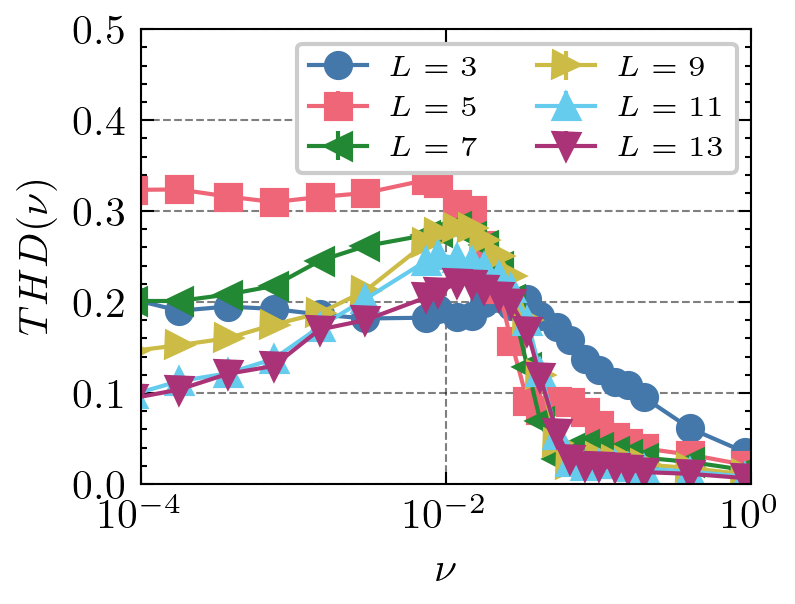

In [229]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
for i, N in enumerate(N_PARTICLES):
    _   = ax.errorbar(x=np.array(FREQ_LIST_MHZ)/F0_SET, y=np.mean(thd_vals[N],axis=1), yerr=np.std(thd_vals[N],axis=1), marker=marker[i], label=rf'$L = {N}$')

_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_ylabel("$THD(\\nu)$")
_ = ax.legend(fontsize='x-small', loc='upper right', ncol=2)
_ = ax.set_ylim(0,0.5)
_ = ax.set_xlim(1e-4,1e0)

fig.savefig(f"plots/pdf/THD_scaling.pdf", transparent=False)
fig.savefig(f"plots/svg/THD_scaling.svg", transparent=True)
fig.savefig(f"plots/png/THD_scaling.png", transparent=False)

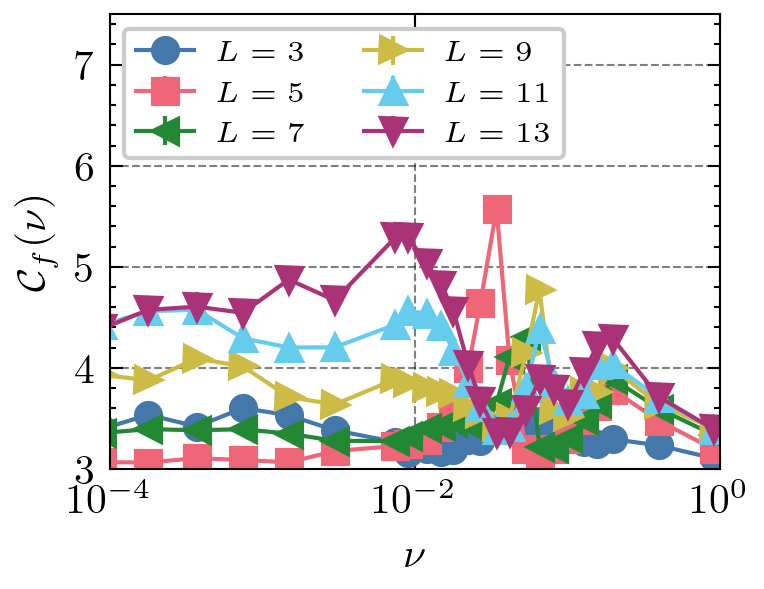

In [230]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
for i, N in enumerate(N_PARTICLES):
    _   = ax.errorbar(x=np.array(FREQ_LIST_MHZ)/F0_SET, y=np.mean(cf_vals[N],axis=1), yerr=np.std(cf_vals[N],axis=1), marker=marker[i], label=rf'$L = {N}$')

_ = ax.set_xscale('log')
_ = ax.set_xlabel("$\\nu$")
_ = ax.set_ylabel("$\\mathcal{C}_f(\\nu)$")
_ = ax.legend(fontsize='x-small', loc='upper left', ncol=2)
# _ = ax.legend(fontsize='x-small', loc='upper right', ncol=1)
_ = ax.set_ylim(3,7.5)
_ = ax.set_xlim(1e-4,1e0)

fig.savefig(f"plots/pdf/cf_scaling.pdf", transparent=False)
fig.savefig(f"plots/svg/cf_scaling.svg", transparent=True)
fig.savefig(f"plots/png/cf_scaling.png", transparent=False)

### Memory Capacity (does not really make sense here)

In [48]:
def memory_capacity(x: np.ndarray, u: np.ndarray, lags: np.ndarray) -> tuple[float, np.ndarray]:
    """
    Calculates the Linear Memory Capacity (MC) analytically using covariance matrices.
    
    This measures how much information about the past input u(t-k) is contained 
    linearly within the reservoir state x(t). It is equivalent to the R^2 score 
    of an optimally trained linear readout for each lag.

    Parameters:
    -----------
    x : np.ndarray
        State matrix of shape (steps, N_nodes). 
        Can be Potentials (recommended) or Charges.
    u : np.ndarray
        Input signal of shape (steps,).
    lags : np.ndarray or list
        Integer delays k to evaluate (e.g., np.arange(1, 100)).

    Returns:
    --------
    total_mc : float
        Sum of MC over all provided lags.
    mc_k : np.ndarray
        The specific MC values for each lag.
    """
    
    # 1. Preprocessing: Center the data (Remove Mean)
    # We ignore the intercept term by centering, which simplifies the math.
    X_centered = x - np.mean(x, axis=0)
    u_centered = u - np.mean(u)
    
    T = X_centered.shape[0]
    
    # 2. Compute State Covariance Matrix (Sigma_X)
    # Shape: (N, N)
    Sigma_X = (X_centered.T @ X_centered) / (T - 1)
    
    # 3. Compute Pseudo-Inverse of Sigma_X
    # We use pinv (Pseudo-inverse) because if nodes are highly correlated 
    # (e.g., neighbors in a chain), the matrix is singular/ill-conditioned.
    Sigma_X_inv = np.linalg.pinv(Sigma_X)
    
    # 4. Variance of Input (Normalization factor)
    var_u = np.var(u_centered, ddof=1)
    
    mc_k = []
    
    for k in lags:
        if k == 0:
            # Zero lag is usually not considered "memory", but we can calc it.
            # No shifting needed.
            u_shifted = u_centered
            valid_indices = slice(None)
        else:
            # Shift input back by k steps: u(t-k)
            # We must truncate the arrays to align valid data points.
            # x[k:] corresponds to u[0:-k] (which represents u at t-k)
            u_shifted = u_centered[:-k]
            X_truncated = X_centered[k:]
            
            # Recalculate covariances for the truncated segment to be exact
            # (Or assume stationarity and use full X. Truncation is safer for short series.)
            # Cross-Covariance p_k = Cov(x(t), u(t-k))
            p_k = (X_truncated.T @ u_shifted) / (len(u_shifted) - 1)
            
            # 5. Calculate MC_k
            # Formula: p_k.T @ Sigma_inv @ p_k / var(u)
            # This is mathematically identical to the R^2 of a linear regression.
            score = (p_k.T @ Sigma_X_inv @ p_k) / var_u
            
            # R^2 cannot theoretically exceed 1.0, but numerical noise might cause 1.000001
            score = min(score, 1.0)
            mc_k.append(score)

    mc_k = np.array(mc_k)
    total_mc = np.sum(mc_k)
    
    return total_mc, mc_k

In [80]:
n_per       = 10
lags        = np.arange(1, SAMPLE_P_PERIOD*n_per)
mc_s        = {N : [memory_capacity(p[N][freq],x[N][freq],lags)[0] for freq in FREQ_LIST_MHZ] for N in N_PARTICLES}
mc_I        = {N : [memory_capacity(y[N][freq][:,np.newaxis],x[N][freq],lags)[0] for freq in FREQ_LIST_MHZ] for N in N_PARTICLES}
mc_s_vs_lag = {N : {freq : memory_capacity(p[N][freq],x[N][freq],lags) for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
mc_I_vs_lag = {N : {freq : memory_capacity(y[N][freq][:,np.newaxis],x[N][freq],lags) for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}

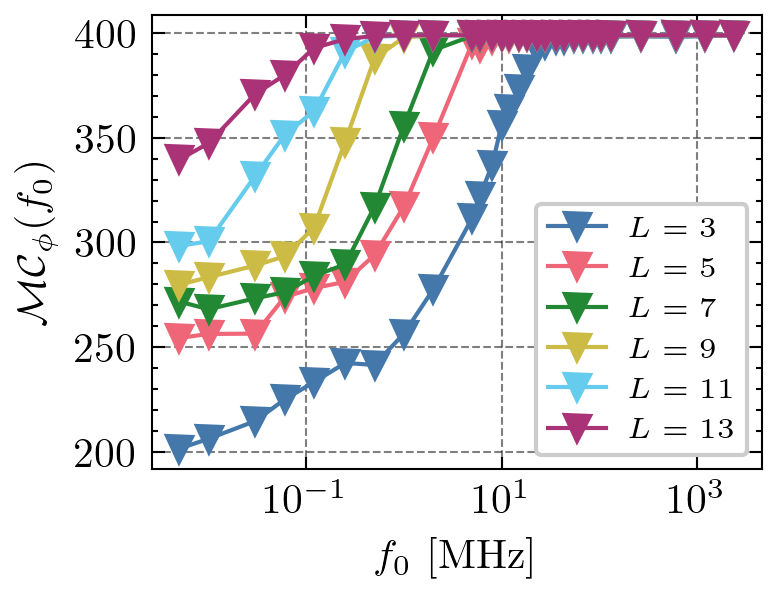

In [ ]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
for N in N_PARTICLES:
    _   = ax.plot(FREQ_LIST_MHZ, mc_s[N], marker=marker[i], label=rf'$L = {N}$')

_ = ax.set_xscale('log')
_ = ax.set_xlabel("$f_0$ [MHz]")
_ = ax.set_ylabel("$\mathcal{MC}_{\phi}(f_0)$")
_ = ax.legend(fontsize='x-small', loc='lower right', ncol=1)

# fig.savefig(f"plots/pdf/pot_f0_MC_scaling.pdf", transparent=False)
# fig.savefig(f"plots/svg/pot_f0_MC_scaling.svg", transparent=True)
# fig.savefig(f"plots/png/pot_f0_MC_scaling.png", transparent=False)

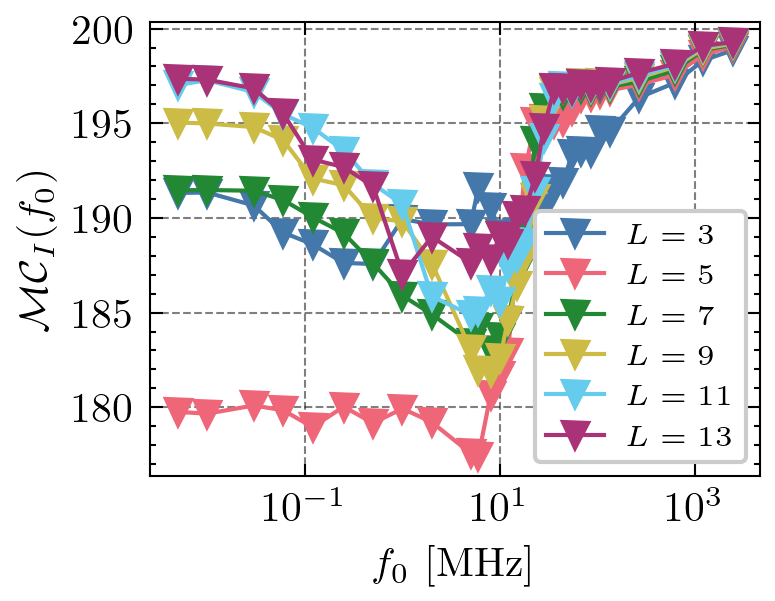

In [ ]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)
for N in N_PARTICLES:
    _   = ax.plot(FREQ_LIST_MHZ, mc_I[N], marker=marker[i], label=rf'$L = {N}$')

_ = ax.set_xscale('log')
_ = ax.set_xlabel("$f_0$ [MHz]")
_ = ax.set_ylabel("$\mathcal{MC}_{I}(f_0)$")
_ = ax.legend(fontsize='x-small', loc='lower right', ncol=1)

# fig.savefig(f"plots/pdf/I_f0_MC_scaling.pdf", transparent=False)
# fig.savefig(f"plots/svg/I_f0_MC_scaling.svg", transparent=True)
# fig.savefig(f"plots/png/I_f0_MC_scaling.png", transparent=False)

### Spatial Distribution

In [119]:
N_NP     = 13
topo = {"Nx": N_NP,"Ny": N_NP, "e_pos": [[(N_NP-1)//2, 0],[0, 0],[N_NP-1, 0],
               [0, (N_NP-1)//2],[N_NP-1, (N_NP-1)//2],[0, N_NP-1],
               [N_NP-1, N_NP-1],[(N_NP-1)//2, N_NP-1]],
            "electrode_type": ['constant']*8}
sim_class   = Simulation(topo)
G_obj       = sim_class.get_graph()
pos         = sim_class.get_positions()
pos         = {(key+8 if key >= 0 else (abs(key)-1)) : (val) for key, val in pos.items()}
E_CHARGE    = sim_class.ELE_CHARGE_A_C
CAP_MAT     = sim_class.get_capacitance_matrix()
t_points = [0,int(0.25*SAMPLE_P_PERIOD),int(0.5*SAMPLE_P_PERIOD),int(0.75*SAMPLE_P_PERIOD)]
phi_vecs = {}
q_vecs   = {}
t_vecs   = {}
x_vecs   = {}
y_vecs   = {}

for freq in FREQ_LIST_MHZ:

    t       = time[freq][:-1][:-N_SKIP*SAMPLE_P_PERIOD]*1e9
    phi_vec = p_s[N_NP][freq]
    q_vec   = (CAP_MAT @ phi_vec.T).T/E_CHARGE

    phi_vecs[freq]  = phi_vec.copy()
    q_vecs[freq]    = q_vec.copy()
    t_vecs[freq]    = t.copy()
    x_vecs[freq]    = x.copy()
    y_vecs[freq]    = y.copy()

In [120]:
def analyze_lattice_with_moments(arr: np.ndarray):
    """
    Analyzes the full 2D lattice using a model-free moment-based approach on projected profiles.

    Calculates the "center of charge" (mean) and "charge spread" (RMS width)
    for the FULL distribution projected onto the horizontal (x) and vertical (y) axes.

    Args:
        arr (np.ndarray): A 9x9 NumPy array of the lattice state (charge or potential).

    Returns:
        Tuple[float, float, float, float]: A tuple containing:
            - mean_x (float): The center of charge along the x-axis.
            - width_x (float): The RMS spread of charge along the x-axis (Lateral Spread).
            - mean_y (float): The center of charge along the y-axis (Penetration Depth).
            - width_y (float): The RMS spread of charge along the y-axis (Longitudinal Spread).
    """
    ny, nx = arr.shape
    x_coords = np.arange(nx)
    y_coords = np.arange(ny)

    # Use absolute values as weights (magnitude of excitation)
    weights = np.abs(arr)
    total_weight = np.sum(weights)

    # Avoid division by zero if there's no charge
    if total_weight == 0:
        return np.nan, np.nan, np.nan, np.nan

    # --- 1. Project 2D Data to 1D Axes ---
    # Instead of taking a single slice, we SUM over the perpendicular axis.
    # This captures charge moving in the "wings," not just the center line.
    profile_x = np.sum(weights, axis=0)  # Sum columns to get X distribution
    profile_y = np.sum(weights, axis=1)  # Sum rows to get Y distribution

    # --- 2. Calculate Moments for X ---
    # Mean position X
    mean_x = np.sum(x_coords * profile_x) / total_weight
    
    # RMS width X
    var_x = np.sum(((x_coords - mean_x)**2) * profile_x) / total_weight
    width_x = np.sqrt(var_x)

    # --- 3. Calculate Moments for Y ---
    # Mean position Y
    mean_y = np.sum(y_coords * profile_y) / total_weight
    
    # RMS width Y
    var_y = np.sum(((y_coords - mean_y)**2) * profile_y) / total_weight
    width_y = np.sqrt(var_y)

    return mean_x, width_x, mean_y, width_y

N_samples   = 20
q_c_max     = []
q_c_zero    = []
phi_c_max   = []
phi_c_zero  = []
charge      = True

for freq in FREQ_LIST_MHZ:
    vals = [analyze_lattice_with_moments(q_vecs[freq][i*SAMPLE_P_PERIOD].copy().reshape(N_NP,N_NP)) for i in range(N_samples)]
    q_c_zero.append(vals)

    vals = [analyze_lattice_with_moments(q_vecs[freq][i*SAMPLE_P_PERIOD + int(0.25*SAMPLE_P_PERIOD)].copy().reshape(N_NP,N_NP)) for i in range(N_samples)]
    q_c_max.append(vals)

    vals = [analyze_lattice_with_moments(phi_vecs[freq][i*SAMPLE_P_PERIOD].copy().reshape(N_NP,N_NP)) for i in range(N_samples)]
    phi_c_zero.append(vals)

    vals = [analyze_lattice_with_moments(phi_vecs[freq][i*SAMPLE_P_PERIOD + int(0.25*SAMPLE_P_PERIOD)].copy().reshape(N_NP,N_NP)) for i in range(N_samples)]
    phi_c_max.append(vals)

if charge:
    mean_x_max  = np.array([[q_c_max[i][j][0] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_x_max = np.array([[q_c_max[i][j][1] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    mean_y_max  = np.array([[q_c_max[i][j][2] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_y_max = np.array([[q_c_max[i][j][3] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])

    mean_x_zero     = np.array([[q_c_zero[i][j][0] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_x_zero    = np.array([[q_c_zero[i][j][1] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    mean_y_zero     = np.array([[q_c_zero[i][j][2] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_y_zero    = np.array([[q_c_zero[i][j][3] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
else:
    mean_x_max  = np.array([[phi_c_max[i][j][0] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_x_max = np.array([[phi_c_max[i][j][1] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    mean_y_max  = np.array([[phi_c_max[i][j][2] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_y_max = np.array([[phi_c_max[i][j][3] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])

    mean_x_zero     = np.array([[phi_c_zero[i][j][0] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_x_zero    = np.array([[phi_c_zero[i][j][1] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    mean_y_zero     = np.array([[phi_c_zero[i][j][2] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_y_zero    = np.array([[phi_c_zero[i][j][3] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])

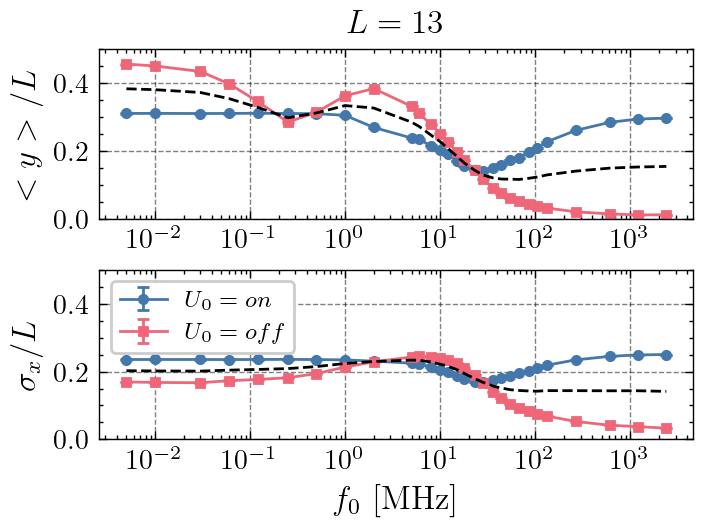

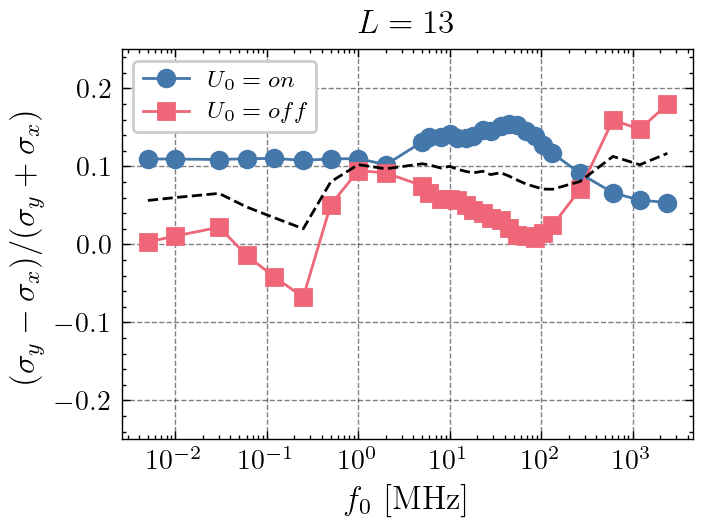

In [121]:
fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot(2,1,1)
ax.errorbar(FREQ_LIST_MHZ, np.mean(mean_y_max,axis=1)/N_NP, 1.95*np.std(mean_y_max,axis=1)/(N_NP*np.sqrt(N_samples)), marker='o', capsize=2, label='$U_0 = on$', ms=3)
ax.errorbar(FREQ_LIST_MHZ, np.mean(mean_y_zero,axis=1)/N_NP, 1.95*np.std(mean_y_zero,axis=1)/(N_NP*np.sqrt(N_samples)), marker='s', capsize=2, label='$U_0 = off$', ms=3)
ax.plot(FREQ_LIST_MHZ, (np.mean(mean_y_max,axis=1)+np.mean(mean_y_zero,axis=1))/(2*N_NP), '--', color='black', zorder=10)
_ = ax.set_title(f"$L = {N_NP}$")
_ = ax.set_ylabel("$<y> / L$", fontsize='large')
_ = ax.set_xscale('log')
_ = ax.set_ylim(0,0.5)
ax = fig.add_subplot(2,1,2)
ax.errorbar(FREQ_LIST_MHZ, np.mean(width_x_max,axis=1)/N_NP, 1.95*np.std(width_x_max,axis=1)/(N_NP*np.sqrt(N_samples)), marker='o', capsize=2, label='$U_0 = on$', ms=3)
ax.errorbar(FREQ_LIST_MHZ, np.mean(width_x_zero,axis=1)/N_NP, 1.95*np.std(width_x_zero,axis=1)/(N_NP*np.sqrt(N_samples)), marker='s', capsize=2, label='$U_0 = off$', ms=3)
ax.plot(FREQ_LIST_MHZ, (np.mean(width_x_max,axis=1)+np.mean(width_x_zero,axis=1))/(2*N_NP), '--', color='black', zorder=10)
_ = ax.set_xscale('log')
_ = ax.set_ylim(0,0.5)
_ = ax.set_xlabel("$f_0$ [MHz]", fontsize='large')
_ = ax.set_ylabel("$\sigma_x / L$", fontsize='large')
_ = ax.legend(fontsize='small', loc='upper left')

if charge:
    fig.savefig(f"plots/svg/charge_penetration_{N_NP}.svg", transparent=True)
    fig.savefig(f"plots/pdf/charge_penetration_{N_NP}.pdf", transparent=False)
    fig.savefig(f"plots/png/charge_penetration_{N_NP}.png", transparent=False)
else:
    fig.savefig(f"plots/svg/pot_penetration_{N_NP}.svg", transparent=True)
    fig.savefig(f"plots/pdf/pot_penetration_{N_NP}.pdf", transparent=False)
    fig.savefig(f"plots/png/pot_penetration_{N_NP}.png", transparent=False)

fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot()
ax.plot(FREQ_LIST_MHZ, (np.mean(width_y_max,axis=1)-np.mean(width_x_max,axis=1))/(np.mean(width_y_max,axis=1)+np.mean(width_x_max,axis=1)),'-o', label='$U_0 = on$')
ax.plot(FREQ_LIST_MHZ, (np.mean(width_y_zero,axis=1)-np.mean(width_x_zero,axis=1))/(np.mean(width_y_zero,axis=1)+np.mean(width_x_zero,axis=1)),'-s', label='$U_0 = off$')
ax.plot(FREQ_LIST_MHZ, ((np.mean(width_y_max,axis=1)-np.mean(width_x_max,axis=1))/(np.mean(width_y_max,axis=1)+np.mean(width_x_max,axis=1))+
                        (np.mean(width_y_zero,axis=1)-np.mean(width_x_zero,axis=1))/(np.mean(width_y_zero,axis=1)+np.mean(width_x_zero,axis=1)))/2, '--', color='black', zorder=10)
# _ = ax.set_title(f"$U_0 = {amp*1000}$ mV")
_ = ax.set_ylabel("$(\sigma_y-\sigma_x)/(\sigma_y+\sigma_x)$", fontsize='large')
_ = ax.set_xlabel("$f_0$ [MHz]", fontsize='large')
_ = ax.set_xscale('log')
_ = ax.set_title(f"$L = {N_NP}$")
_ = ax.set_ylim(-0.25,0.25)
_ = ax.legend(fontsize='small', loc='upper left')
if charge:
    fig.savefig(f"plots/svg/charge_anisotropy_{N_NP}.svg", transparent=True)
    fig.savefig(f"plots/pdf/charge_anisotropy_{N_NP}.pdf", transparent=False)
    fig.savefig(f"plots/png/charge_anisotropy_{N_NP}.png", transparent=False)
else:
    fig.savefig(f"plots/svg/pot_anisotropy_{N_NP}.svg", transparent=True)
    fig.savefig(f"plots/pdf/pot_anisotropy_{N_NP}.pdf", transparent=False)
    fig.savefig(f"plots/png/pot_anisotropy_{N_NP}.png", transparent=False)